# Document Clustering and Concept extraction

In [1]:
from pathlib import Path
import sys
import re

parent = Path().absolute().parents[0].as_posix()

sys.path.insert(0, parent)

from tqdm import tqdm
from collections import Counter

import pandas as pd
import numpy as np

import pickle
import gensim
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
%matplotlib inline

## Load data

In [2]:
articles = pd.read_csv('../data/scraping_data.csv.gz', compression='gzip')
articles['source'] = articles['link'].apply(lambda val: re.findall(r"(?<=[http|s:]//)\w+", val)[1])

In [3]:
with open('../data/processed/words_embedded.pickle', 'rb') as handle:
    words_emb = pickle.load(handle)

In [4]:
with open('../data/processed/docs_cleaned.pickle', 'rb') as handle:
    docs_cleaned = pickle.load(handle)

In [5]:
with open('../data/processed/docs_keywords_sentiment.pickle', 'rb') as handle:
    docs_keywords_w_sentiment = pickle.load(handle)

In [6]:
with open('../data/processed/docs_keywords.pickle', 'rb') as handle:
    docs_keywords = pickle.load(handle)

In [7]:
model = gensim.models.Word2Vec.load('../models/trained/word2vec.model')

In [8]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(docs_cleaned)
feature_array = vectorizer.get_feature_names()

tf_idf_values = dict(list(zip(feature_array,vectorizer.idf_,)))

/home/joao/.cache/pypoetry/virtualenvs/smart_archive-LyPfE8oW-py3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [9]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(docs_cleaned)
feature_array = vectorizer.get_feature_names()
freq_values = dict(zip(vectorizer.get_feature_names(), X.sum(0).getA1()))
                           

In [ ]:
tf_idf_values

In [9]:
X = [val[0] for val in words_emb]

In [ ]:
distortions = []
cluster_numbers = range(2, 20)
for k in cluster_numbers:
    k_means = KMeans(n_clusters=k, random_state=0)
    k_means.fit(X)
    distortions.append(sum(np.min(cdist(X, k_means.cluster_centers_, 'euclidean'), axis=1)) / len(X))


X_line = [cluster_numbers[0], cluster_numbers[-1]]
Y_line = [distortions[0], distortions[-1]]

plt.figure(figsize=(10,10))
plt.plot(cluster_numbers, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


In [10]:
kmeans = KMeans(n_clusters=12, random_state=0, max_iter=1000)
kmeans.fit(X)

KMeans(max_iter=1000, n_clusters=12, random_state=0)

In [11]:
concept_mapping = dict(list(zip([val[1] for val in words_emb], kmeans.labels_)))

In [ ]:
concept_mapping

In [12]:
len(kmeans.labels_)

92921

In [13]:
res = pd.DataFrame()
res['Word'] = [val[1] for val in words_emb]
res['Emb'] = [val[0] for val in words_emb]
res['Concept'] = kmeans.labels_

In [14]:
res.Concept.value_counts()

3     72554
2      3847
7      3743
0      2165
9      1902
4      1612
8      1608
1      1575
6      1499
5      1320
11     1004
10       92
Name: Concept, dtype: int64

In [26]:
for concept in np.unique(kmeans.labels_):
    print('Concept:', concept)
    print(model.wv.most_similar(positive=[np.mean(res[res.Concept==concept]['Emb'])], topn=20))

Concept: 0
[('argumentista', 0.6774632334709167), ('atriz', 0.6601378917694092), ('pianista', 0.6515897512435913), ('trilogia', 0.6514281630516052), ('compositor', 0.64143306016922), ('trompetista', 0.6307846307754517), ('cantores', 0.6246402263641357), ('dramaturgo', 0.6176615953445435), ('romancista', 0.6173108220100403), ('guitarrista', 0.6170833110809326), ('editou', 0.614407479763031), ('gotico', 0.6125814914703369), ('escritor', 0.6119500994682312), ('literario', 0.6096832752227783), ('cineasta', 0.6081852316856384), ('cantora', 0.6072835922241211), ('ilustrador', 0.6071503162384033), ('coreografa', 0.6070607900619507), ('ator', 0.6025753021240234), ('contrabaixista', 0.6020599007606506)]
Concept: 1
[('socialista', 0.6637467741966248), ('assumida', 0.6458436250686646), ('secretariogeral', 0.6401174664497375), ('rejeitou', 0.6326475143432617), ('acaloradamente', 0.6259049773216248), ('socialista.', 0.6255477070808411), ('assumiu', 0.6236230134963989), ('criticou', 0.62196385860443

In [15]:
n_concepts = 12
tf_idf_concepts = []
for doc in docs_cleaned:
    temp = {key: [] for key in range(0, n_concepts)}
    for word in doc.split(' '):
        try:
            temp[concept_mapping[word]].append(tf_idf_values[word])
        except KeyError:
            continue
    tf_idf_concepts.append({k:np.mean(v) for k,v in temp.items()})

/home/joao/.cache/pypoetry/virtualenvs/smart_archive-LyPfE8oW-py3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/joao/.cache/pypoetry/virtualenvs/smart_archive-LyPfE8oW-py3.9/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [16]:
docs_concepts = pd.DataFrame(tf_idf_concepts)
docs_concepts.fillna(0, inplace=True)

In [17]:
docs_concepts.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,4.227586,3.866104,7.019558,7.933520,3.548455,4.751178,4.435950,6.119298,4.955144,3.694541,2.348786,4.572175
1,4.910398,4.095354,5.730766,8.676509,4.005181,6.480411,4.795413,7.206609,3.980406,3.641122,2.198344,4.429381
2,5.323303,4.190256,5.967059,8.470373,3.957898,5.170066,5.114350,6.811530,4.203864,3.967080,0.000000,4.113963
3,6.251882,4.233328,5.602932,8.819256,4.640020,0.000000,3.703077,6.651636,4.880003,4.781878,1.967922,3.297878
4,4.740547,3.858763,6.325240,8.298091,3.925220,3.650748,4.087613,7.747382,4.772175,4.284123,2.463260,4.128317


In [18]:
concepts = pd.DataFrame(columns=['Concept'])
concepts['Concept'] = docs_concepts.idxmax(axis=1)

In [19]:
concepts.head()

,Concept
0,3
1,3
2,3
3,3
4,3


In [20]:
concepts.Concept.value_counts()

3     17640
7      4630
2      3937
1       754
8       720
5       698
9       665
0       585
11      575
6       385
4       123
Name: Concept, dtype: int64

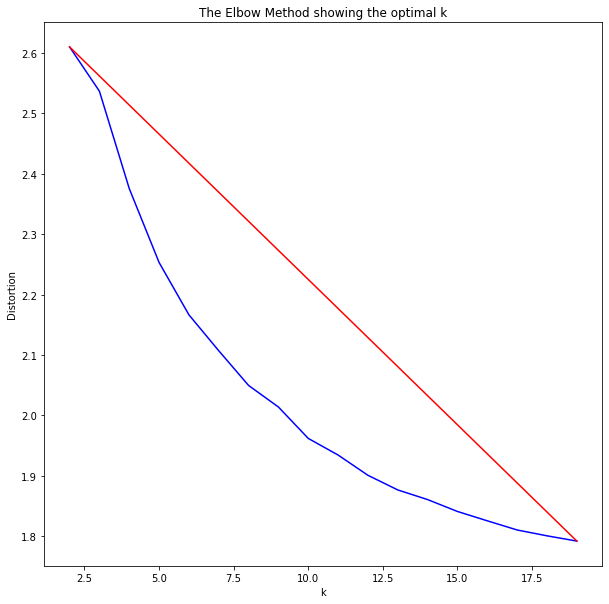

In [112]:
distortions = []
cluster_numbers = range(2, 20)
scaler = StandardScaler()
docs_concepts_scaled = scaler.fit_transform(docs_concepts)
for k in cluster_numbers:
    k_means = KMeans(n_clusters=k, random_state=0)
    k_means.fit(docs_concepts_scaled)
    distortions.append(sum(np.min(cdist(docs_concepts_scaled, k_means.cluster_centers_, 'euclidean'), axis=1)) / len(docs_concepts_scaled))


X_line = [cluster_numbers[0], cluster_numbers[-1]]
Y_line = [distortions[0], distortions[-1]]

plt.figure(figsize=(10,10))
plt.plot(cluster_numbers, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [92]:
ks = range(2, 12)
results = {}
for k in ks: 
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(docs_concepts)
    results[k] = silhouette_score(docs_concepts, kmeans.labels_)
    print(results)

{2: 0.3340066958357645}
{2: 0.3340066958357645, 3: 0.22729697814831942}
{2: 0.3340066958357645, 3: 0.22729697814831942, 4: 0.20883761465587766}
{2: 0.3340066958357645, 3: 0.22729697814831942, 4: 0.20883761465587766, 5: 0.2188760146287086}
{2: 0.3340066958357645, 3: 0.22729697814831942, 4: 0.20883761465587766, 5: 0.2188760146287086, 6: 0.22868826896333413}
{2: 0.3340066958357645, 3: 0.22729697814831942, 4: 0.20883761465587766, 5: 0.2188760146287086, 6: 0.22868826896333413, 7: 0.21456827477248358}
{2: 0.3340066958357645, 3: 0.22729697814831942, 4: 0.20883761465587766, 5: 0.2188760146287086, 6: 0.22868826896333413, 7: 0.21456827477248358, 8: 0.20254582014788639}
{2: 0.3340066958357645, 3: 0.22729697814831942, 4: 0.20883761465587766, 5: 0.2188760146287086, 6: 0.22868826896333413, 7: 0.21456827477248358, 8: 0.20254582014788639, 9: 0.18027063959497064}
{2: 0.3340066958357645, 3: 0.22729697814831942, 4: 0.20883761465587766, 5: 0.2188760146287086, 6: 0.22868826896333413, 7: 0.21456827477248358

In [21]:
scaler = StandardScaler()
kmeans = KMeans(n_clusters=7, random_state=0, max_iter=1000)
kmeans.fit(scaler.fit_transform(docs_concepts))

KMeans(max_iter=1000, n_clusters=7, random_state=0)

In [22]:
w = pd.DataFrame(kmeans.labels_, columns=['cluster'])

In [23]:
w.head()

,cluster
0,0
1,0
2,0
3,0
4,0


In [24]:
w.cluster.value_counts()

6    6093
3    6040
1    5963
5    4570
0    4414
2    3363
4     269
Name: cluster, dtype: int64

In [25]:
res = pd.merge(articles[['city', 'year', 'title', 'content']], w, left_index=True, right_index=True)
res['keywords'] = docs_keywords
res['concepts'] = concepts['Concept']


In [35]:
res.head()

,city,year,title,content,cluster,keywords,concepts
0,Lisboa,1999,POL | Local Lisboa,POL | Local Lisboa SECÇÕES 1ª Página Destaque ...,0,"[(pagina ficha tecnica, 0.006355170236059001),...",3
1,Lisboa,1999,JN Editorial - Text57,JN Editorial - Text57 26 milhões para dar casa...,0,"[(desenvolver vertente habitacional, 0.0382880...",3
2,Lisboa,1999,Outras Paginas,Outras Paginas 11 de Novembro de 1999 Igreja d...,0,"[(aberta comunidade declarado, 0.0089504002322...",3
3,Lisboa,1999,JN Editorial - Texult1,JN Editorial - Texult1 Macau: Rão Kyao é o aut...,0,"[(influencias orientais autor, 0.0123850332999...",3
4,Lisboa,1999,PÚBLICONLINE-Os Destaques da Primeira Página,PÚBLICONLINE-Os Destaques da Primeira Página S...,0,"[(pagina seccoes pagina, 0.003380441747381107)...",3


In [ ]:
res[res.year == 2020].head(50)

In [37]:
'portalegre' in res.tail(50).content.iloc[10].lower().split(' ')

True

In [38]:
res.tail(50).title.iloc[10].lower()

'expresso | urbanismo pode ser fator diferenciador nas regiões'

In [39]:
res[(res.year==2020)].head()

,city,year,title,content,cluster,keywords,concepts
4097,Lisboa,2020,Expresso | Lisboa,Expresso | Lisboa Loja Siga-nos Facebook Twitt...,3,"[(semanario atualidade recebe, 0.0377123788679...",3
4098,Lisboa,2020,Expresso | Lisboa bate recorde em cruzeiros,Expresso | Lisboa bate recorde em cruzeiros Lo...,2,"[(ganharia maioria absoluta., 0.03219179260590...",3
4099,Lisboa,2020,Expresso | Fórmula 1 vai 'parar' Lisboa,Expresso | Fórmula 1 vai 'parar' Lisboa Loja S...,2,"[(atualidade apresentar cosmopolis., 0.0102441...",3
4100,Lisboa,2020,Expresso | Que Lisboa é esta?,Expresso | Que Lisboa é esta? Loja Siga-nos Fa...,5,"[(atualidade arquivo manifestantes, 0.02921389...",2
4101,Lisboa,2020,Expresso | 2017 – uma odisseia em Lisboa,Expresso | 2017 – uma odisseia em Lisboa Loja ...,2,"[(avenida naus reabriu., 0.03461371156732152),...",7


In [44]:
i = 4
res[(res.year==2020)].iloc[i]

city                                                   Lisboa
year                                                     2020
title                Expresso | 2017 – uma odisseia em Lisboa
content     Expresso | 2017 – uma odisseia em Lisboa Loja ...
cluster                                                     2
keywords    [(avenida naus reabriu., 0.03461371156732152),...
concepts                                                    7
Name: 4101, dtype: object

In [ ]:
res[(res.year==2020)].iloc[i].content

In [ ]:
res[(res.year==2020)].iloc[i].keywords

In [ ]:
list(zip(res[(res.cluster==1) & (res.year==2020)].title.to_list(), res[(res.cluster==1) & (res.year==2020)].keywords.to_list()))

In [ ]:
res[(res.year==2019)]

In [3]:
articles[(articles.year==2019)]

,Unnamed: 0,city,title,content,year,tstamp,link,source
2793,2793,Lisboa,Expresso | PSP de Lisboa detém falso polícia p...,Expresso | PSP de Lisboa detém falso polícia p...,2019,20191014194634,https://arquivo.pt/wayback/20191014194634/http...,expresso
2794,2794,Lisboa,Expresso | Lisboa,Expresso | Lisboa Assinar Loja Siga-nos Facebo...,2019,20190724011414,https://arquivo.pt/wayback/20190724011414/http...,expresso
2795,2795,Lisboa,Lisboa | Lisboa | PÚBLICO,Lisboa | Lisboa | PÚBLICO Ir para o conteúdo I...,2019,20190831124050,https://arquivo.pt/wayback/20190831124050/http...,publico
2796,2796,Lisboa,Expresso | PSD-Lisboa,Expresso | PSD-Lisboa Assinar Loja Siga-nos Fa...,2019,20190523013111,https://arquivo.pt/wayback/20190523013111/http...,expresso
2797,2797,Lisboa,Transportes | Lisboa | PÚBLICO,Transportes | Lisboa | PÚBLICO Ir para o conte...,2019,20190905221513,https://arquivo.pt/wayback/20190905221513/http...,publico
...,...,...,...,...,...,...,...,...
30597,30597,Portalegre,Expresso | #VazaJato,Expresso | #VazaJato Assinar Loja Siga-nos Fac...,2019,20190611182649,https://arquivo.pt/wayback/20190611182649/http...,expresso
30598,30598,Portalegre,Expresso | Liberdade para pensar,Expresso | Liberdade para pensar Assinar Loja ...,2019,20190829025053,https://arquivo.pt/wayback/20190829025053/http...,expresso
30599,30599,Portalegre,Expresso | A história secreta da geringonça,Expresso | A história secreta da geringonça As...,2019,20190522143846,https://arquivo.pt/wayback/20190522143846/http...,expresso
30600,30600,Portalegre,Uma autocaravana (e um drama) que percorre o i...,Uma autocaravana (e um drama) que percorre o i...,2019,20190905222158,https://arquivo.pt/wayback/20190905222158/http...,publico


In [52]:
'portalegre' in articles.tail(50).content.iloc[10].lower().split(' ')

False

In [68]:
articles.shape

(30759, 7)

In [4]:
articles.dropna(inplace=True)

In [5]:
articles.shape

(30712, 8)

In [6]:
articles['check'] = articles.apply(lambda val: val['city'].lower() in val['content'].lower(), axis=1)

In [7]:
articles['check'].value_counts()

True     30270
False      442
Name: check, dtype: int64

In [8]:
articles[articles['check']==True]

,Unnamed: 0,city,title,content,year,tstamp,link,source,check
0,0,Lisboa,POL | Local Lisboa,POL | Local Lisboa SECÇÕES 1ª Página Destaque ...,1999,19991111042737,https://arquivo.pt/wayback/19991111042737/http...,publico,True
1,1,Lisboa,JN Editorial - Text57,JN Editorial - Text57 26 milhões para dar casa...,1999,19990822002536,https://arquivo.pt/wayback/19990822002536/http...,jn,True
2,2,Lisboa,Outras Paginas,Outras Paginas 11 de Novembro de 1999 Igreja d...,1999,19991117215651,https://arquivo.pt/wayback/19991117215651/http...,jn,True
3,3,Lisboa,JN Editorial - Texult1,JN Editorial - Texult1 Macau: Rão Kyao é o aut...,1999,19991118004529,https://arquivo.pt/wayback/19991118004529/http...,jn,True
4,4,Lisboa,PÚBLICONLINE-Os Destaques da Primeira Página,PÚBLICONLINE-Os Destaques da Primeira Página S...,1999,19991012235908,https://arquivo.pt/wayback/19991012235908/http...,publico,True
...,...,...,...,...,...,...,...,...,...
30754,30754,Portalegre,"Expresso | Aviso laranja em Viseu, Aveiro e Co...","Expresso | Aviso laranja em Viseu, Aveiro e Co...",2021,20201217220804,https://arquivo.pt/wayback/20201217220804/http...,expresso,True
30755,30755,Portalegre,Expresso | Presidenciais: Ventura e Le Pen jun...,Expresso | Presidenciais: Ventura e Le Pen jun...,2021,20201221183315,https://arquivo.pt/wayback/20201221183315/http...,expresso,True
30756,30756,Portalegre,Expresso | António Costa aponta porta de saída...,Expresso | António Costa aponta porta de saída...,2021,20201214221824,https://arquivo.pt/wayback/20201214221824/http...,expresso,True
30757,30757,Portalegre,Expresso | O que esperar da solidariedade em 2...,Expresso | O que esperar da solidariedade em 2...,2021,20201225190530,https://arquivo.pt/wayback/20201225190530/http...,expresso,True


In [84]:
articles[articles.index.isin([30755])]

,Unnamed: 0,city,title,content,year,tstamp,link,check
30755,30755,Portalegre,Expresso | Presidenciais: Ventura e Le Pen jun...,Expresso | Presidenciais: Ventura e Le Pen jun...,2021,20201221183315,https://arquivo.pt/wayback/20201221183315/http...,True


In [ ]:
articles[articles.index.isin([30755])].content.to_list()

In [109]:
articles['title'].apply(lambda val: re.findall(r'.*(?=\|)', val)[0][0:10] if len(re.findall(r'.*(?=\|)', val)) else None).value_counts()

Expresso      12762
50% DESCON      605
40% DESCON      436
30% DESCON      391
45% DESCON      211
              ...  
Câmara do         1
Associação        1
Sporting |        1
Estradas |        1
António Vi        1
Name: title, Length: 465, dtype: int64

In [9]:
articles[articles['title'].str.lower().str.startswith('jn')].year.value_counts()

2000    48
2001    44
1999    21
2002    13
Name: year, dtype: int64

In [10]:
articles['source'].value_counts()

expresso    12862
publico     11380
jn           6469
dn              1
Name: source, dtype: int64

In [11]:
articles.groupby(['source','year']).size()

source    year
dn        2016       1
expresso  2010       2
          2012      11
          2013       7
          2014      38
          2015      39
          2016       1
          2019    5553
          2020    6278
          2021     933
jn        1999      37
          2000     130
          2001     294
          2002     187
          2003      22
          2004      15
          2005      15
          2008      11
          2013     133
          2014    5613
          2015      12
publico   1999      73
          2000      63
          2001       2
          2002       3
          2003       7
          2004      14
          2005       3
          2007      19
          2008      15
          2009       6
          2010     826
          2011    1210
          2012     394
          2013    3314
          2014     980
          2015    2120
          2016    1651
          2019     680
dtype: int64

In [39]:
df = articles.groupby(['source','year', 'city']).size().reset_index(name='count')
df[df.city=='Setúbal']

,source,year,city,count
47,expresso,2019,Setúbal,281
65,expresso,2020,Setúbal,282
83,expresso,2021,Setúbal,47
100,jn,1999,Setúbal,2
118,jn,2000,Setúbal,7
136,jn,2001,Setúbal,19
154,jn,2002,Setúbal,7
184,jn,2004,Setúbal,1
199,jn,2005,Setúbal,1
226,jn,2013,Setúbal,8


In [12]:
# Garbage JN articles
articles[(articles['source'] == 'jn') & (articles['title'].str.contains('DESCONTO'))].year.value_counts()

2014    5273
Name: year, dtype: int64

In [25]:
articles[(articles['source'] == 'expresso')].year.value_counts()

2020    6278
2019    5553
2021     933
2015      39
2014      38
2012      11
2013       7
2010       2
2016       1
Name: year, dtype: int64

In [26]:
articles[(articles['source'] == 'jn')].year.value_counts()

2014    5613
2001     294
2002     187
2013     133
2000     130
1999      37
2003      22
2004      15
2005      15
2015      12
2008      11
Name: year, dtype: int64

In [27]:
articles[(articles['source'] == 'publico')].year.value_counts()

2013    3314
2015    2120
2016    1651
2011    1210
2014     980
2010     826
2019     680
2012     394
1999      73
2000      63
2007      19
2008      15
2004      14
2003       7
2009       6
2005       3
2002       3
2001       2
Name: year, dtype: int64

In [ ]:
articles[(articles['source'] == 'publico')].iloc[-50].content

In [186]:
articles[(articles['source'] == 'publico')].iloc[-50].title

'António Saraiva - PÚBLICO'

In [187]:
articles[(articles['source'] == 'publico')].iloc[-50].link

'https://arquivo.pt/wayback/20150602191628/http://publico.pt/antonio-saraiva'

In [ ]:
list(zip(articles[(articles['source'] == 'publico')].link.to_list(), articles[(articles['source'] == 'publico')].year.to_list()))[-20:]

In [ ]:
list(zip(articles[(articles['source'] == 'jn')].link.to_list(), articles[(articles['source'] == 'jn')].year.to_list()))[-200:]